In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

# Image compression from scratch

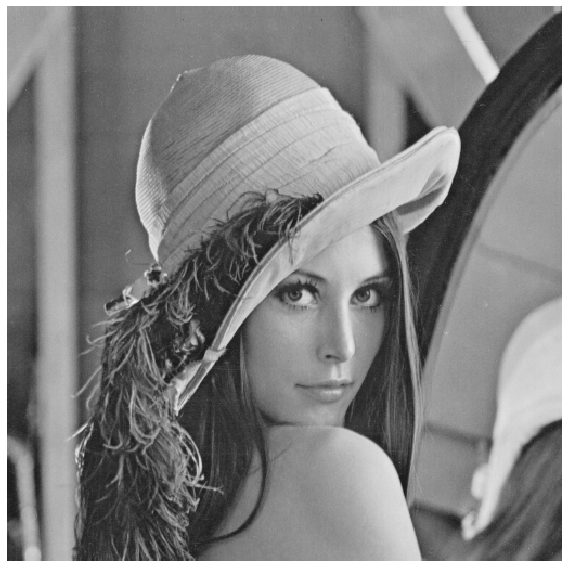

In [2]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import jpeg
from plotters import (
    load_image,
    plot_compare,
    plot_image,
    plot_patch,
    plot_pixel_values,
)


image_path = Path('..', 'images', 'lena512.bmp')
im = load_image(image_path)
plot_image(im);

# Image size

We expect the image size to change:
1. when the picture dimensions (shape), i.e. the total number of pixels changes;
2. when the amount of bits per pixel changes.

In case of `2.`, pixels now are in between `0` and `255`, i.e. there are 256 unique possible value. Therefore we need `8` bits per pixel to encode a pixel value.

In [4]:
from operator import mul

image_size = lambda shape, bits_per_pixel=8: mul(*shape) * bits_per_pixel

In [5]:
image_size(im.shape)

2097152

The left image takes 62.5% less bits to encode image.


(<Figure size 720x576 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1405e28d0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1406a5590>))

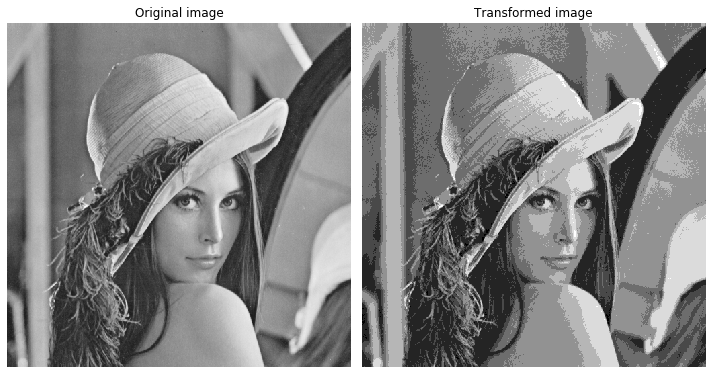

In [9]:
bits_per_pixel = 3
nunique_values = 2 ** bits_per_pixel

im_scaled = ((im / 256) * nunique_values).astype(int)

im_size = image_size(im.shape)
im_scaled_size = image_size(im_scaled.shape, bits_per_pixel)
compression_rate = im_scaled_size / im_size
print(f'The left image takes {(1 - im_scaled_size / im_size) * 100}% less bits to encode image.')

plot_compare(im, im_scaled)

The left image takes 75.0% less bits to encode image.


(<Figure size 720x576 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1408e4850>,
  <matplotlib.axes._subplots.AxesSubplot at 0x13fd0ddd0>))

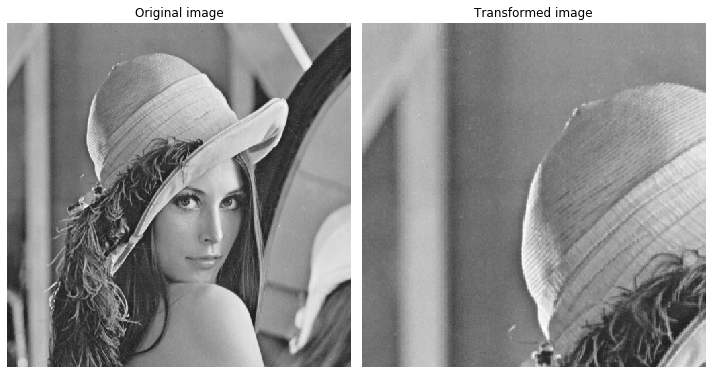

In [11]:
scaled_height = int(im.shape[0] / 2)
scaled_width = int(im.shape[1] / 2)

im_scaled = im[:scaled_height, :scaled_width]

im_size = image_size(im.shape)
im_scaled_size = image_size(im_scaled.shape, bits_per_pixel=8)
compression_rate = im_scaled_size / im_size
print(f'The left image takes {(1 - im_scaled_size / im_size) * 100}% less bits to encode image.')

plot_compare(im, im_scaled)

# Downsample

The left image takes 75.0% less bits to encode image.


(<Figure size 720x576 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x13fdbca10>,
  <matplotlib.axes._subplots.AxesSubplot at 0x13fec2150>))

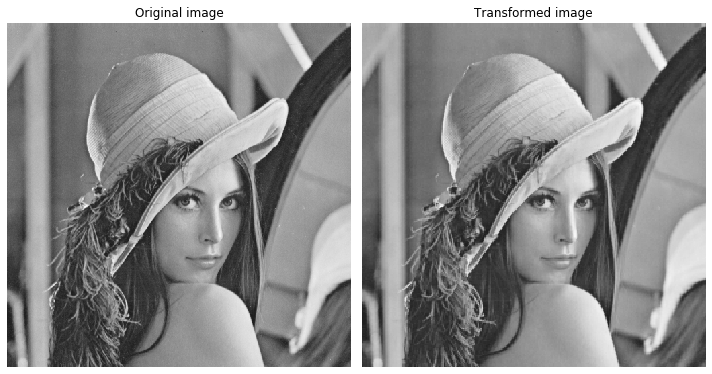

In [12]:
patch_size = 2

values = []
for y in range(0, im.shape[0], patch_size):
    for x in range(0, im.shape[0], patch_size):
        patch = im[y: y + patch_size, x: x + patch_size]
        val = np.mean(patch)
        values.append(val)
        
scaled_height = int(im.shape[0] / 2)
scaled_width = int(im.shape[1] / 2)
im_scaled = np.array(values).reshape((scaled_height, scaled_width))

im_size = image_size(im.shape)
im_scaled_size = image_size(im_scaled.shape, bits_per_pixel=8)
compression_rate = im_scaled_size / im_size
print(f'The left image takes {(1 - im_scaled_size / im_size) * 100}% less bits to encode image.')

plot_compare(im, im_scaled)

(<Figure size 720x576 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1409e9b50>,
  <matplotlib.axes._subplots.AxesSubplot at 0x140a02950>))

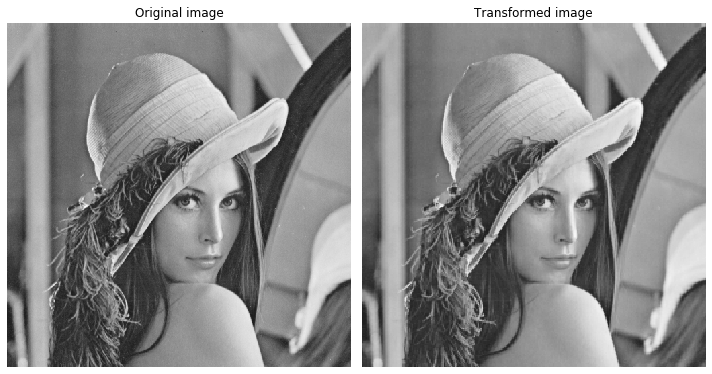

In [16]:
def generate_patches(im, *, patch_size=8):
    for y in range(0, im.shape[0], patch_size):
        for x in range(0, im.shape[1], patch_size):
            patch = im[y: y + patch_size, x: x + patch_size]
            yield patch
            
            
def downsample(im, func, *, patch_size=8):
    values = [
        func(patch)
        for patch in generate_patches(im, patch_size=patch_size)
    ]
    
    scaled_height = int(im.shape[0] / patch_size)
    scaled_width = int(im.shape[1] / patch_size)
    return np.array(values).reshape((scaled_height, scaled_width))

im_scaled = downsample(im, np.mean, patch_size=2)

plot_compare(im, im_scaled)

(<Figure size 720x576 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x140a45050>,
  <matplotlib.axes._subplots.AxesSubplot at 0x140a5d410>))

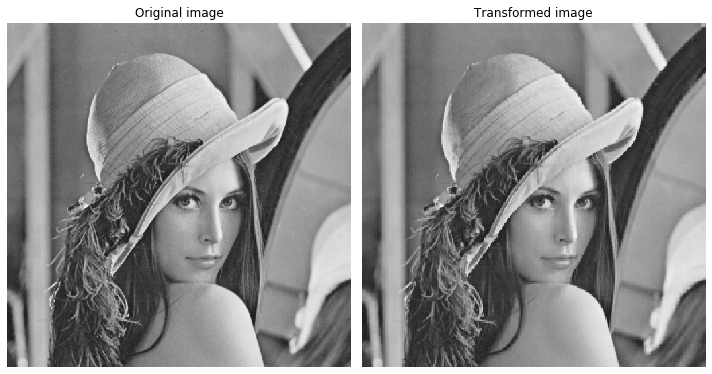

In [18]:
im_scaled = downsample(im, np.median, patch_size=2)
plot_compare(im, im_scaled)

(<Figure size 720x576 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x140afc690>,
  <matplotlib.axes._subplots.AxesSubplot at 0x140b19610>))

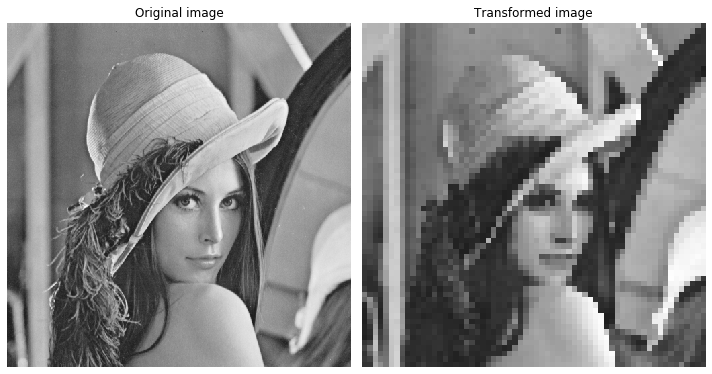

In [20]:
im_scaled = downsample(im, np.min, patch_size=8)
plot_compare(im, im_scaled) 

(<Figure size 720x576 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x140b5d510>,
  <matplotlib.axes._subplots.AxesSubplot at 0x140b81a10>))

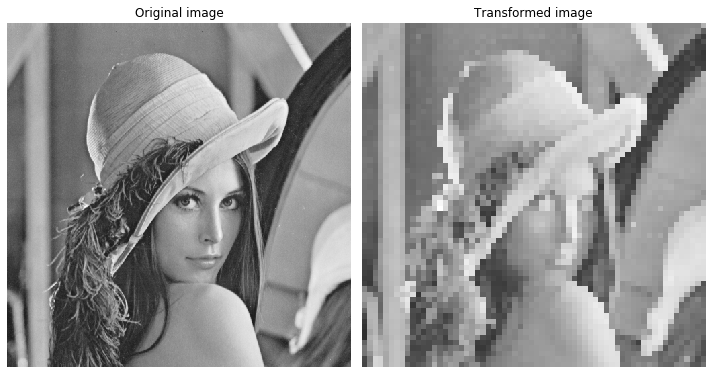

In [21]:
im_scaled = downsample(im, np.max, patch_size=8)
plot_compare(im, im_scaled) 

In [22]:
patches = list(generate_patches(im))


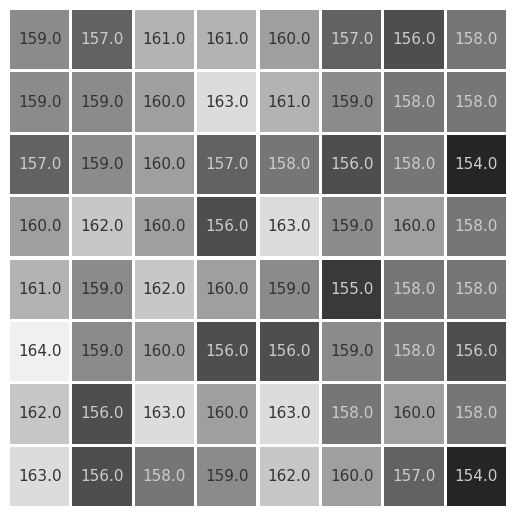

<ggplot: (336328805)>

In [23]:
import random

patch = random.choice(patches)
plot_patch(patch)

# Filters

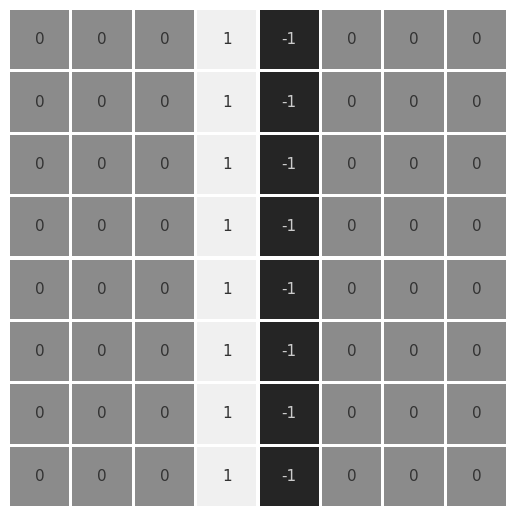

<ggplot: (336283877)>

In [24]:
def apply_filter(patch, filter_):
    if callable(filter_):
        return filter_(patch)
    else:
        return (patch * filter_).sum()
    
ver_line_filter = np.array([
    [0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0, 0, 1, -1, 0, 0, 0],
])


plot_patch(ver_line_filter)

(<Figure size 720x576 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1414f9650>,
  <matplotlib.axes._subplots.AxesSubplot at 0x141529fd0>))

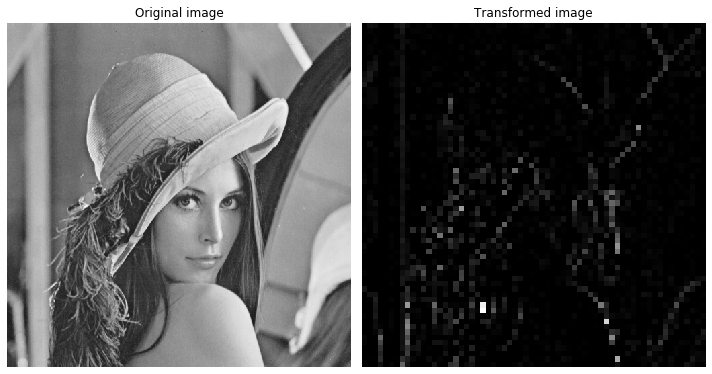

In [27]:
from functools import partial

im_scaled = downsample(im, partial(apply_filter, filter_=ver_line_filter))
plot_compare(im, im_scaled) 

(<Figure size 720x576 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x14159ea50>,
  <matplotlib.axes._subplots.AxesSubplot at 0x141683290>))

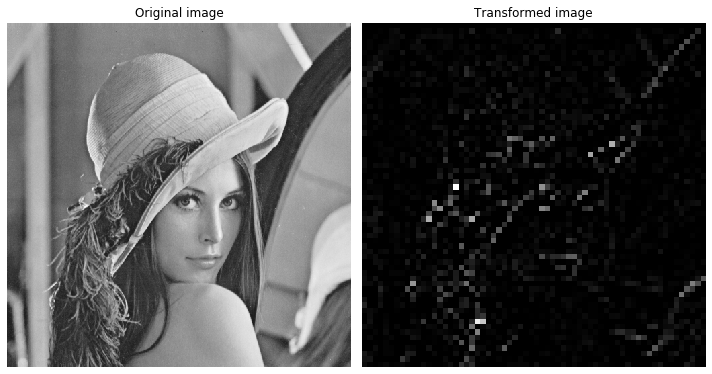

In [28]:
im_scaled = downsample(im, partial(apply_filter, filter_=ver_line_filter.T))
plot_compare(im, im_scaled) 

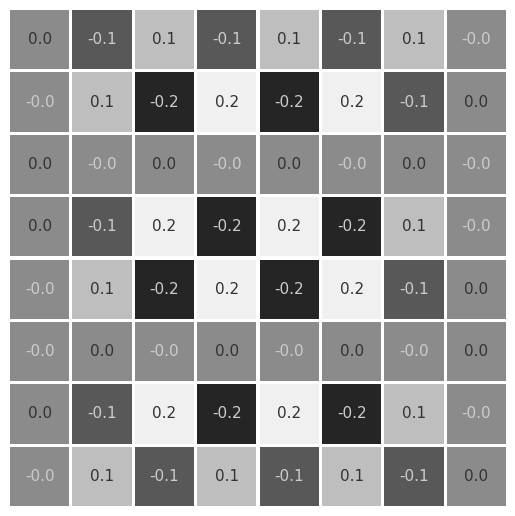

<ggplot: (337130693)>

In [42]:
def discrete_cosine(freq, *, patch_size=8):
    return np.cos(freq * (np.arange(patch_size) + .5) * np.pi / patch_size)


def normalization_constant(freq):
    return 1 / np.sqrt(2) if freq == 0 else 1


def discrete_cosine_filter(freq_ver, freq_hor):
    dc_ver = discrete_cosine(freq_ver).reshape((-1, 1))
    dc_hor = discrete_cosine(freq_hor).reshape((1, -1))
    c = normalization_constant(freq_ver) * normalization_constant(freq_hor)
    return .25 * c * (dc_ver @ dc_hor)

    
dc = discrete_cosine_filter(5, 7)
plot_patch(dc)

(<Figure size 720x576 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x141ad7c50>,
  <matplotlib.axes._subplots.AxesSubplot at 0x141e07490>))

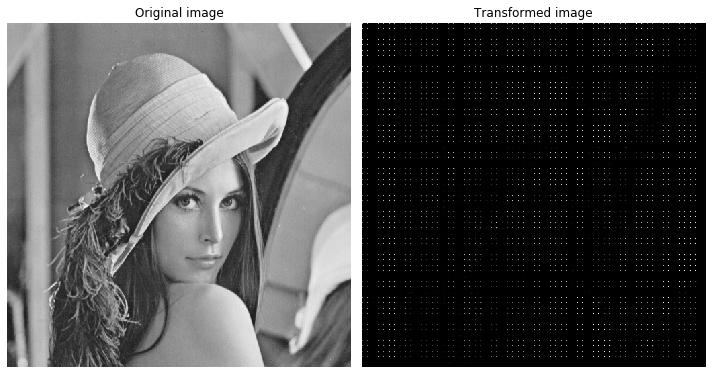

In [44]:
dc_filters = [
    discrete_cosine_filter(u, v)
    for u in range(8)
    for v in range(8)
]


def apply_filters(patch, filters):
    return np.array([apply_filter(patch, filter_) for filter_ in filters])


def transform(im, filters, *, patch_size=8):
    im_transformed = [
        apply_filters(patch, filters).reshape((patch_size, patch_size))
        for patch in generate_patches(im, patch_size=patch_size)
    ]
    
    n_hor_patches = int(im.shape[1] / patch_size)
    return np.vstack([
        np.hstack(im_transformed[y * n_hor_patches: (y + 1) * n_hor_patches])
        for y in range(int(im.shape[0] / patch_size))
    ])

im_dc = transform(im, dc_filters)
plot_compare(im, im_dc)

In [59]:
patches = list(generate_patches(im_dc))

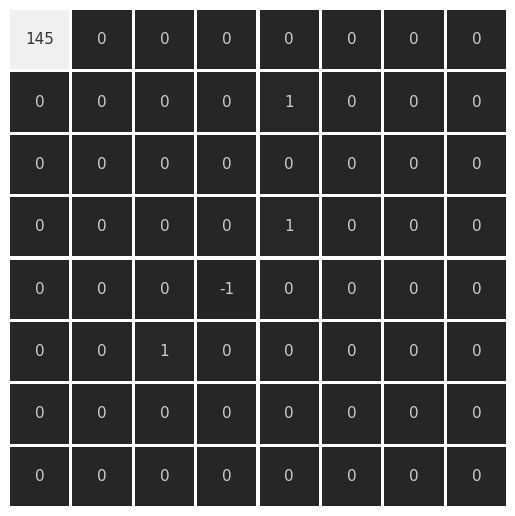

<ggplot: (337156821)>

In [61]:
# patch = random.choice(patches)
plot_patch((patch / 10).astype(int))

/Users/cor/.virtualenvs/pyjpeg/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 15916'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


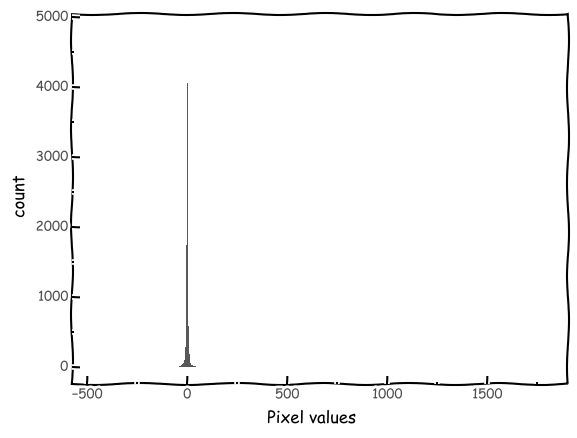

<ggplot: (337595245)>

In [47]:
plot_pixel_values(im_dc)

In [48]:
im_dc.min(), im_dc.max()

(-465.36779326428393, 1788.9999999999998)

- 237 -> '11101101'
- 27 -> '00011011'

In [51]:
from jpeg.utils import int_to_bits

int_to_bits(27).zfill(8)

'00011011'

- '10010011'
  - '1001' -> leading zero
  - '0011' -> number bits needed to encode value

In [54]:
def encode(patch):
    leading_zeros = 0
    bit_string = ''
    for val in patch:
        if val == 0:
            leading_zeros += 1
            continue
            
        # 15 leading zeros
        while leading_zeros >= 15:
            bit_string += '1' * 4 + '0' * 4
            leading_zeros -= 15
            
        # Number of leading zeros
        bit_string += int_to_bits(leading_zeros).zfill(4)
        
        val_in_bits = int_to_bits(abs(val))
        # Number of bits needed to encode the value
        bit_string += int_to_bits(len(val_in_bits)).zfill(4)
        
        bit_string += '1' if val < 0 else '0'
        bit_string += val_in_bits
        
        leading_zeros = 0
        
    # End of block
    bit_string += '0' * 8
        
    return bit_string

In [57]:
from jpeg.utils import zigzag_patch

len(encode(zigzag_patch(patch.astype(int))))

727

In [62]:
from jpeg import compress, decompress

In [64]:
Q = 3
bit_string = compress(im, Q=Q)

im_back = decompress(bit_string, Q=Q)

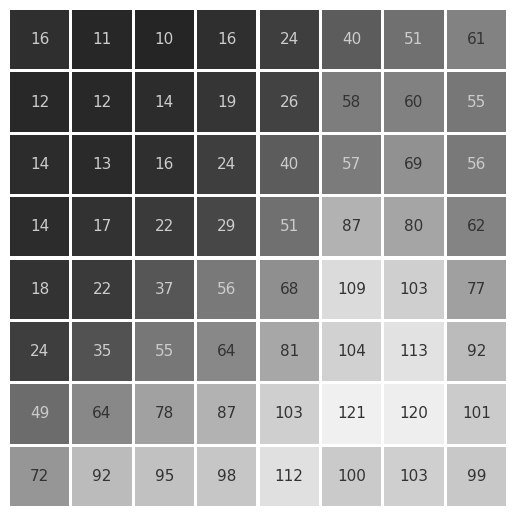

<ggplot: (339802077)>

In [69]:
from jpeg.quantization import quantization_50

plot_patch(quantization_50)

In [68]:
(1 - len(bit_string) / image_size(im.shape)) * 100

43.46928596496582

(<Figure size 720x576 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1412ff710>,
  <matplotlib.axes._subplots.AxesSubplot at 0x141d19bd0>))

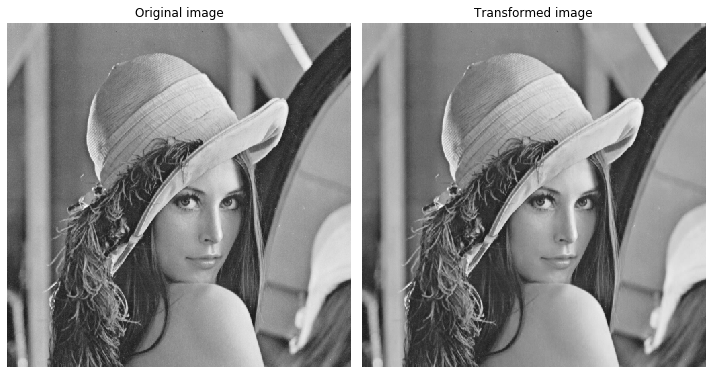

In [65]:
plot_compare(im, im_back)